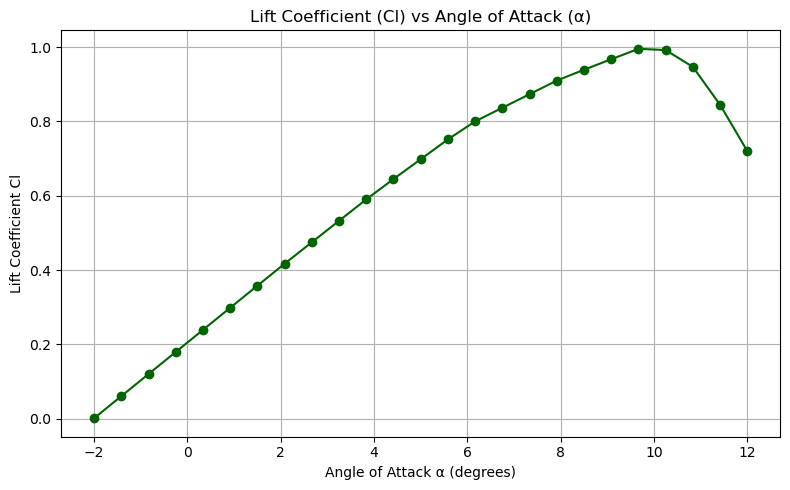

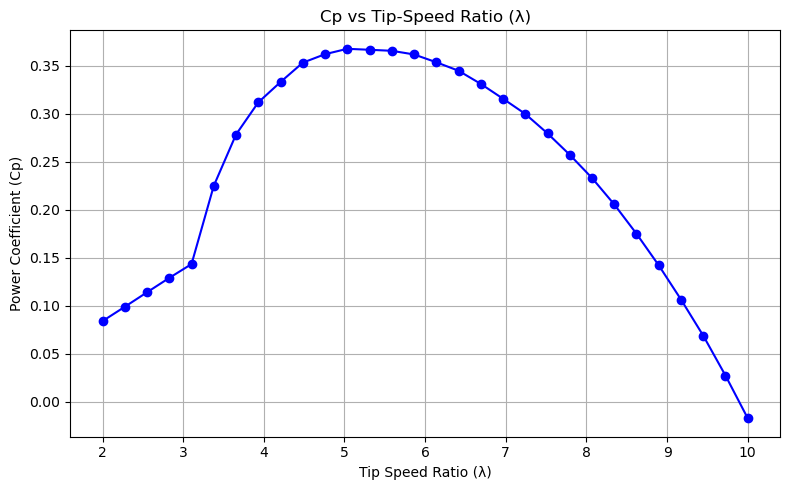

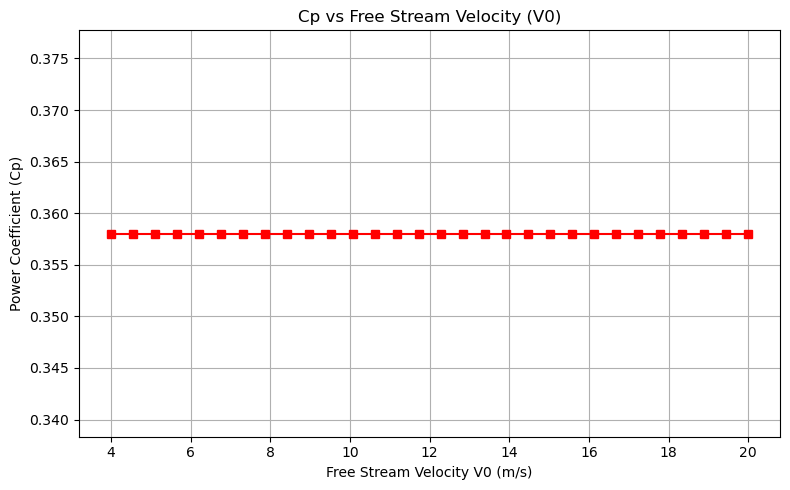

r = 0.10 m / Fn = 28.95 N/m / Ft = 73.84 N/m / Torque = 1.48 Nm / P_local = 14.77 W / Cp_local = 0.0002
r = 0.30 m / Fn = 64.86 N/m / Ft = 94.66 N/m / Torque = 5.68 Nm / P_local = 56.80 W / Cp_local = 0.0008
r = 0.50 m / Fn = 99.44 N/m / Ft = 104.75 N/m / Torque = 10.47 Nm / P_local = 104.75 W / Cp_local = 0.0015
r = 0.70 m / Fn = 138.93 N/m / Ft = 112.03 N/m / Torque = 15.68 Nm / P_local = 156.85 W / Cp_local = 0.0023
r = 0.90 m / Fn = 185.50 N/m / Ft = 118.12 N/m / Torque = 21.26 Nm / P_local = 212.61 W / Cp_local = 0.0031
r = 1.10 m / Fn = 239.76 N/m / Ft = 123.07 N/m / Torque = 27.08 Nm / P_local = 270.76 W / Cp_local = 0.0039
r = 1.30 m / Fn = 301.54 N/m / Ft = 126.53 N/m / Torque = 32.90 Nm / P_local = 328.99 W / Cp_local = 0.0047
r = 1.50 m / Fn = 460.36 N/m / Ft = 191.83 N/m / Torque = 57.55 Nm / P_local = 575.50 W / Cp_local = 0.0083
r = 1.70 m / Fn = 504.17 N/m / Ft = 192.44 N/m / Torque = 65.43 Nm / P_local = 654.30 W / Cp_local = 0.0094
r = 1.90 m / Fn = 541.33 N/m / Ft = 1

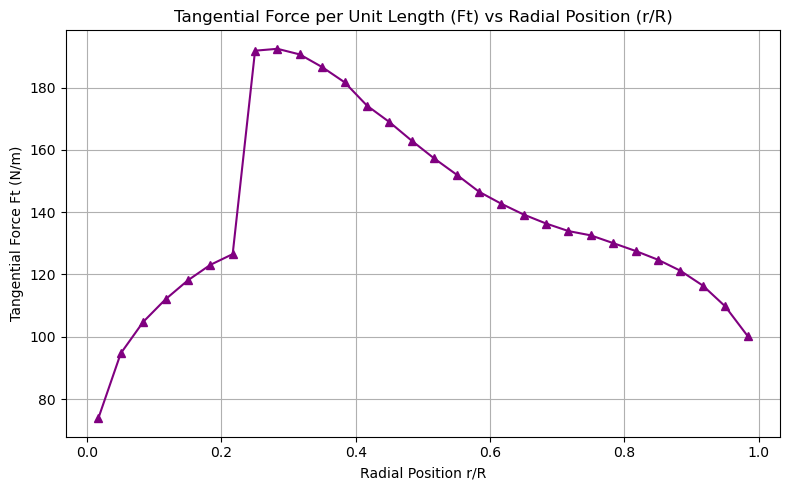

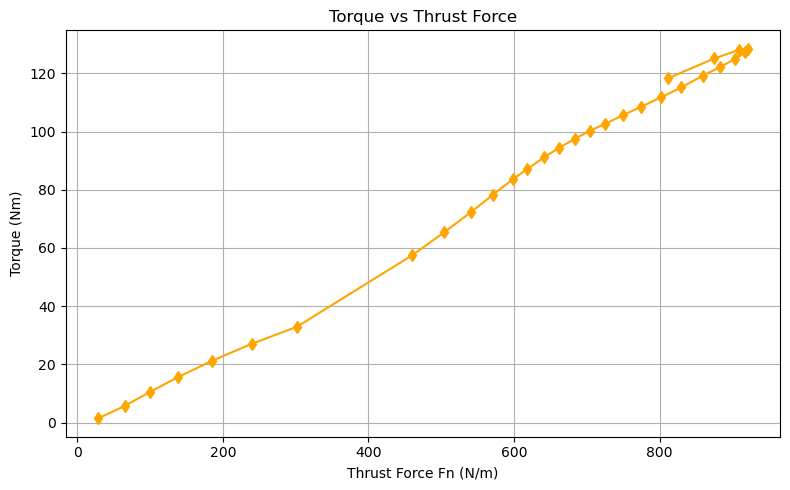

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 24 22:33:34 2025

@author: HP
"""

import numpy as np
import matplotlib.pyplot as plt

# Constants
V0_example = 10  # Free stream velocity
rho = 1.225      # kg/m^3
B = 3            # Number of blades
R = 6            # Rotor radius [m]
n_elements = 30
dr = R / n_elements
tolerance = 1e-3
max_iter = 500

# Airfoil data for NACA2412
airfoil_data = {
    -2: (0.0013, 0.0139),
    0: (0.2051, 0.0132),
    2: (0.4090, 0.0139),
    4: (0.6069, 0.0162),
    6: (0.7899, 0.0204),
    8: (0.9153, 0.0278),
    10: (1.0117, 0.0429),
    11: (0.9339, 0.0639),
    12: (0.72015, 0.1016)
}

def get_Cl_Cd(alpha_deg):
    angles = sorted(airfoil_data.keys())
    for i in range(len(angles) - 1):
        if angles[i] <= alpha_deg <= angles[i + 1]:
            a1, a2 = angles[i], angles[i + 1]
            Cl1, Cd1 = airfoil_data[a1]
            Cl2, Cd2 = airfoil_data[a2]
            f = (alpha_deg - a1) / (a2 - a1)
            return Cl1 + f * (Cl2 - Cl1), Cd1 + f * (Cd2 - Cd1)
    return airfoil_data[angles[0]] if alpha_deg < angles[0] else airfoil_data[angles[-1]]

def chord_distribution(r):
    c_root = 1.0
    c_tip = 0.2
    return c_root * (1 - (r / R)**2) + c_tip * (r / R)**2

def twist_distribution(r):
    twist_root = 20
    twist_tip = 5
    return twist_root + (twist_tip - twist_root) * (r / R)

def bem_solver(V0, omega, return_Fr=False, print_output=False):
    total_power = 0
    total_torque = 0
    A = np.pi * R**2
    Fn_list, r_list, torque_list, Ft_list, thrust_list = [], [], [], [], []

    for i in range(n_elements):
        r = (i + 0.5) * dr
        chord = chord_distribution(r)
        twist_deg = twist_distribution(r)
        a, a_prime = 0.0, 0.0

        for _ in range(max_iter):
            Vrel_axial = V0 * (1 - a)
            Vrel_tangential = omega * r * (1 + a_prime)
            phi = np.arctan2(Vrel_axial, Vrel_tangential)
            alpha = np.degrees(phi) - twist_deg
            Cl, Cd = get_Cl_Cd(alpha)
            Cn = Cl * np.cos(phi) + Cd * np.sin(phi)
            Ct = Cl * np.sin(phi) - Cd * np.cos(phi)
            sigma = chord * B / (2 * np.pi * r)

            a_new = 1 / (1 + (4 * np.sin(phi)**2) / (sigma * Cn))
            a_prime_new = 1 / (1 + (4 * np.sin(phi) * np.cos(phi)) / (sigma * Ct))

            if abs(a_new - a) < tolerance and abs(a_prime_new - a_prime) < tolerance:
                break
            a, a_prime = a_new, a_prime_new

        Vrel = np.sqrt(Vrel_axial**2 + Vrel_tangential**2)
        pT = 0.5 * rho * Vrel**2 * chord * Ct
        dM = r * B * pT * dr
        total_power += omega * dM
        total_torque += dM

        Fn = 0.5 * rho * Vrel**2 * chord * Cn * B
        Ft = 0.5 * rho * Vrel**2 * chord * Ct * B

        if return_Fr:
            Fn_list.append(Fn)
            Ft_list.append(Ft)
            thrust_list.append(Fn)
            torque_list.append(dM)
            r_list.append(r)

            P_local = omega * dM
            Cp_local = P_local / (0.5 * rho * A * V0**3)

            if print_output:
                print(f"r = {r:.2f} m / Fn = {Fn:.2f} N/m / Ft = {Ft:.2f} N/m / Torque = {dM:.2f} Nm / P_local = {P_local:.2f} W / Cp_local = {Cp_local:.4f}")

    Cp = total_power / (0.5 * rho * A * V0**3)

    if print_output:
        lam = omega * R / V0
        print(f"\nTotal Power (W) = {total_power:.2f}")
        print(f"Power Coefficient (Cp) = {Cp:.4f}")
        print(f"Tip-Speed Ratio (\u03bb) = {lam:.2f}")
        print(f"Total Torque (Nm) = {total_torque:.2f}\n")

    if return_Fr:
        return Cp, r_list, Ft_list, total_torque, thrust_list, torque_list
    return Cp, total_power

# Plot Cl vs Alpha
alphas = np.linspace(min(airfoil_data), max(airfoil_data), 25)
Cl_values = [get_Cl_Cd(alpha)[0] for alpha in alphas]

plt.figure(figsize=(8,5))
plt.plot(alphas, Cl_values, 'o-', color='darkgreen')
plt.title("Lift Coefficient (Cl) vs Angle of Attack (α)")
plt.xlabel("Angle of Attack α (degrees)")
plt.ylabel("Lift Coefficient Cl")
plt.grid(True)
plt.tight_layout()
plt.show()

# Cp vs lambda
lambdas = np.linspace(2, 10, 30)
cps_lambda = []
V0_const = 10

for lam in lambdas:
    omega = lam * V0_const / R
    Cp, _ = bem_solver(V0_const, omega)
    cps_lambda.append(Cp)

plt.figure(figsize=(8,5))
plt.plot(lambdas, cps_lambda, 'o-', color='blue')
plt.title("Cp vs Tip-Speed Ratio (λ)")
plt.xlabel("Tip Speed Ratio (λ)")
plt.ylabel("Power Coefficient (Cp)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Cp vs V0
V0s = np.linspace(4, 20, 30)
cps_vo = []
lambda_const = 6

for V0 in V0s:
    omega = lambda_const * V0 / R
    Cp, _ = bem_solver(V0, omega)
    cps_vo.append(Cp)

plt.figure(figsize=(8,5))
plt.plot(V0s, cps_vo, 's-', color='red')
plt.title("Cp vs Free Stream Velocity (V0)")
plt.xlabel("Free Stream Velocity V0 (m/s)")
plt.ylabel("Power Coefficient (Cp)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Tangential Force Ft vs r/R
lambda_example = 6
omega_example = lambda_example * V0_example / R
Cp_dummy, r_vals, Ft_vals, total_torque, thrust_vals, torque_vals = bem_solver(
    V0_example, omega_example, return_Fr=True, print_output=True
)

plt.figure(figsize=(8,5))
plt.plot(np.array(r_vals) / R, Ft_vals, '^-', color='purple')
plt.title("Tangential Force per Unit Length (Ft) vs Radial Position (r/R)")
plt.xlabel("Radial Position r/R")
plt.ylabel("Tangential Force Ft (N/m)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Torque vs Thrust plot
plt.figure(figsize=(8,5))
plt.plot(thrust_vals, torque_vals, 'd-', color='orange')
plt.title("Torque vs Thrust Force")
plt.xlabel("Thrust Force Fn (N/m)")
plt.ylabel("Torque (Nm)")
plt.grid(True)
plt.tight_layout()
plt.show()
